In [78]:
# prompt: Load My dataset from the URL /content/sample_data/unlabelled_train_data_images.npy

import numpy as np

data = np.load('/content/sample_data/unlabelled_train_data_images.npy')
data.shape

(60000, 1, 28, 28)

In [96]:
# prompt: Remove extra dimensions, flatten and normalize the data

from sklearn.preprocessing import normalize

data = data.reshape(data.shape[0], -1)
normalized_data = normalize(data)
normalized_data.shape

(60000, 784)

In [101]:
# prompt: Apply HOG to each image

import numpy as np
!pip install scikit-image

from skimage.feature import hog
from skimage import io

# Assuming normalized_data contains your images as a flat array
# You need to reshape it back to image dimensions before applying HOG
# Let's assume your images were originally 28x28 (like MNIST)
original_image_shape = (28, 28) # Adjust this based on your actual image size
num_images = normalized_data.shape[0]
reshaped_data = normalized_data.reshape(num_images, *original_image_shape)

hog_features = []
for image in reshaped_data:
  # Calculate HOG features for each image
  # Adjust parameters as needed (e.g., pixels_per_cell, cells_per_block)
  features = hog(image, orientations=15, pixels_per_cell=(16, 16),
                 cells_per_block=(1, 1), visualize=False, channel_axis=None)
  hog_features.append(features)

# Convert the list of HOG features to a NumPy array
hog_features = np.array(hog_features)

print("Shape of HOG features:", hog_features.shape)

Shape of HOG features: (60000, 15)


In [102]:
# prompt: HOG features are high dimensional, reduce them using PCA

from sklearn.decomposition import PCA

# Assuming you want to reduce the dimensionality to 100 components
n_components = 10

# Initialize PCA
pca = PCA(n_components=n_components)

# Fit PCA on the HOG features and transform them
hog_features_pca = pca.fit_transform(hog_features)

print("Shape of PCA-reduced HOG features:", hog_features_pca.shape)

# Now hog_features_pca contains the dimensionality-reduced HOG features

Shape of PCA-reduced HOG features: (60000, 10)


In [103]:
# prompt: Apply K-means clustering

from sklearn.cluster import KMeans

# Number of clusters you want to create
n_clusters = 10

# Initialize KMeans
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10) # Added n_init=10 to suppress warning

# Fit KMeans on the PCA-reduced HOG features
kmeans.fit(hog_features_pca)

# Get the cluster assignments for each data point
cluster_assignments = kmeans.labels_

# Get the cluster centers
cluster_centers = kmeans.cluster_centers_

print("Cluster assignments shape:", cluster_assignments.shape)
print("Cluster centers shape:", cluster_centers.shape)

# Now cluster_assignments contains the cluster index for each image,
# and cluster_centers contains the centroid for each cluster in the PCA space.

Cluster assignments shape: (60000,)
Cluster centers shape: (10, 10)


Cluster 0:


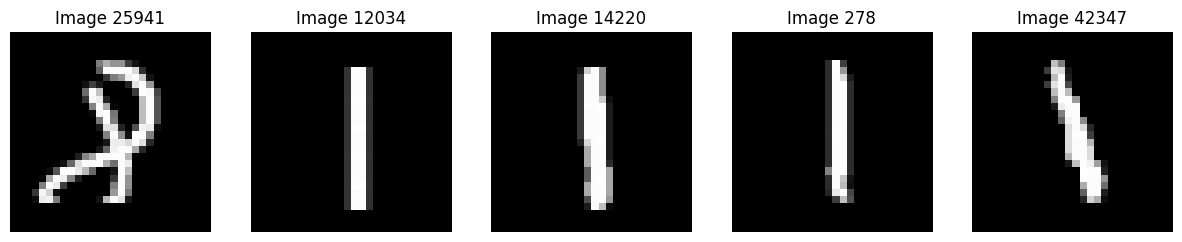

Cluster 1:


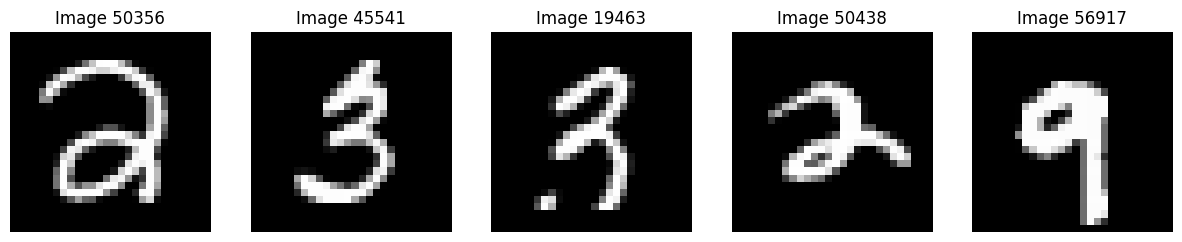

Cluster 2:


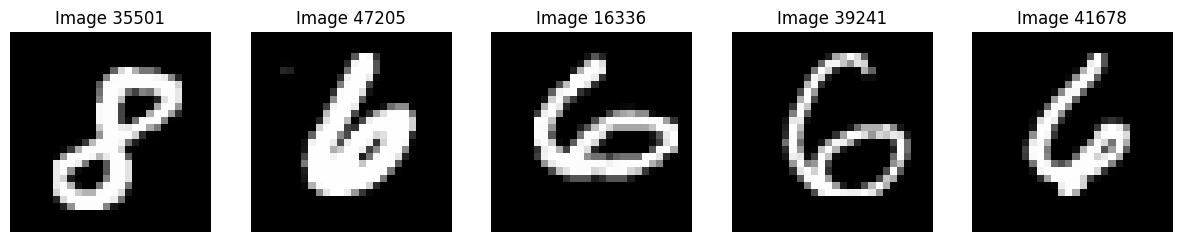

Cluster 3:


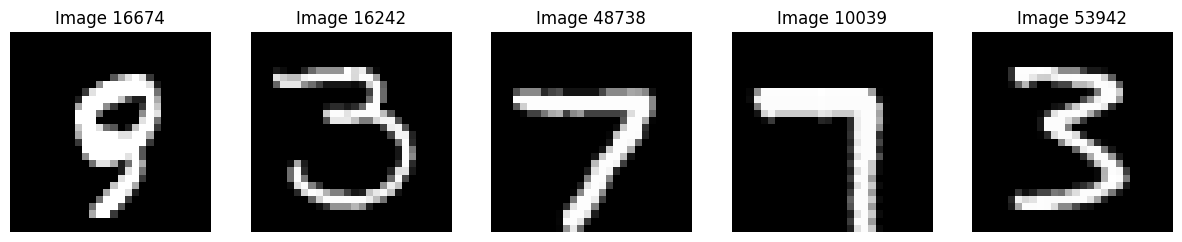

Cluster 4:


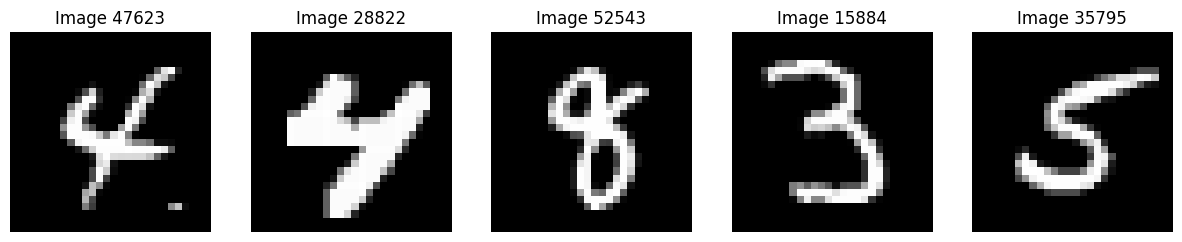

Cluster 5:


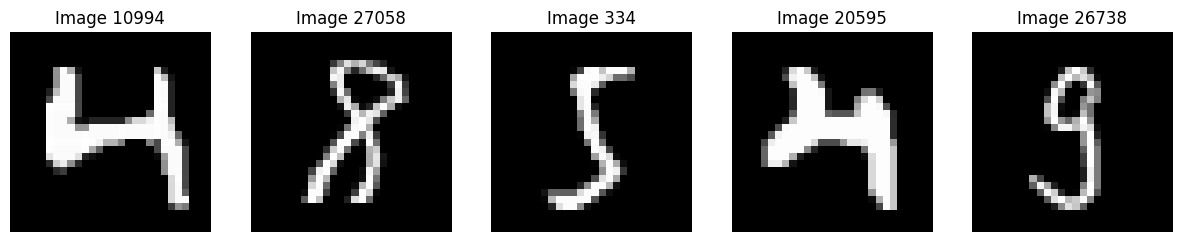

Cluster 6:


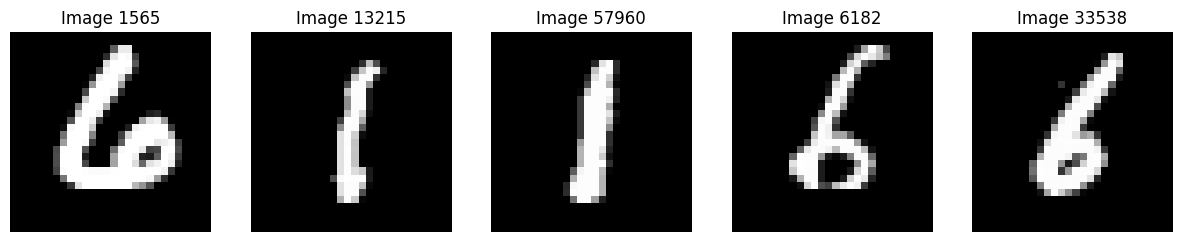

Cluster 7:


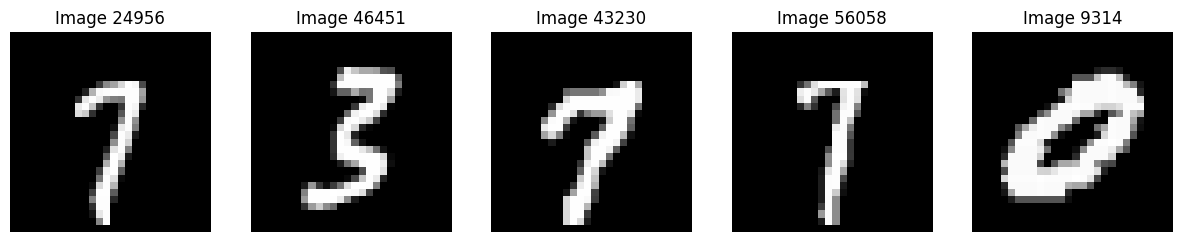

Cluster 8:


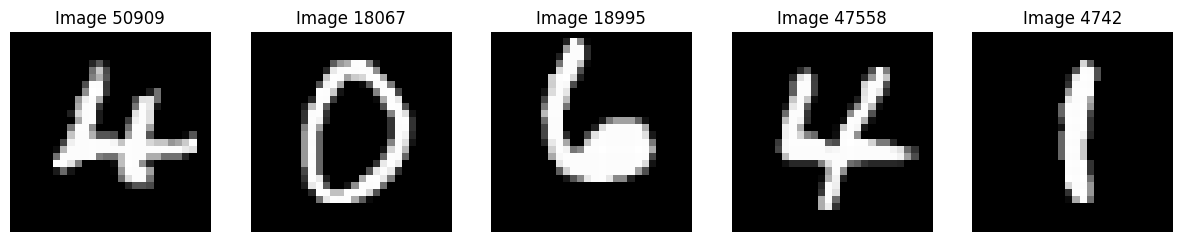

Cluster 9:


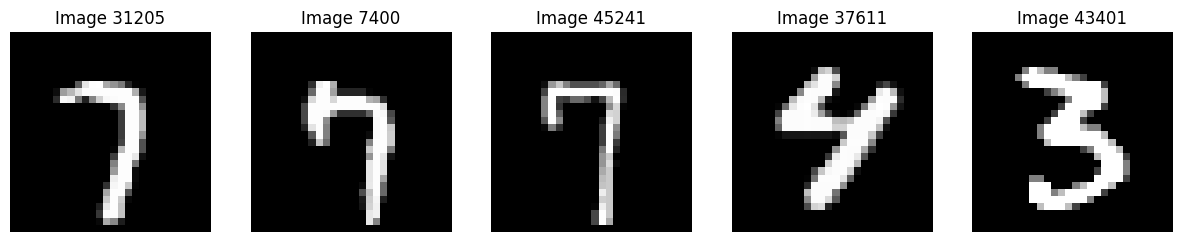

In [109]:
# prompt: Visualization of images from each cluster (based on PCA reduced HOG features)

import matplotlib.pyplot as plt
import numpy as np
# Function to visualize images from each cluster
def visualize_clusters(images, cluster_assignments, n_clusters, images_per_cluster=5):
  """
    Visualizes a few images from each cluster.

    Args:
      images (np.ndarray): The original images array.
      cluster_assignments (np.ndarray): Array of cluster assignments for each image.
      n_clusters (int): The total number of clusters.
      images_per_cluster (int): The number of images to display for each cluster.
    """
  for cluster_id in range(n_clusters):
    print(f"Cluster {cluster_id}:")
    # Get indices of images belonging to the current cluster
    cluster_indices = np.where(cluster_assignments == cluster_id)[0]

    if len(cluster_indices) == 0:
      print("  No images in this cluster.")
      continue

    # Select a few random images from the cluster
    selected_indices = np.random.choice(
        cluster_indices,
        min(images_per_cluster, len(cluster_indices)),
        replace=False,
    )

    # Plot the selected images
    plt.figure(figsize=(15, 5))
    for i, img_index in enumerate(selected_indices):
      plt.subplot(1, images_per_cluster, i + 1)
      plt.imshow(reshaped_data[img_index], cmap="gray") # Assuming grayscale images
      plt.title(f"Image {img_index}")
      plt.axis("off")
    plt.show()


# Visualize images from each cluster
visualize_clusters(data, cluster_assignments, n_clusters=n_clusters)

In [112]:
# prompt: Assign the labelled data to Y_train and the original dataset as X-train
# # Train-test split, use the code snippet below
# X_train, X_val, y_train, y_val = train_test_split(X_pca, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

from sklearn.model_selection import train_test_split

# Y_train is the variable holding the cluster labels
Y_train = cluster_assignments
# X_train should be the original dataset used for feature extraction,
# in this case, the scaled features used for K-Means clustering.
X_train_data = hog_features_pca

# Train-test split using the provided snippet structure
# as the input data (X_train_data) and the labels as the target (Y_train).
X_train, X_val, y_train, y_val = train_test_split(X_train_data, Y_train, test_size=0.2, random_state=42, stratify=Y_train)

print("Train-validation split complete.")
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_val:", y_val.shape)


Train-validation split complete.
Shape of X_train: (48000, 10)
Shape of X_val: (12000, 10)
Shape of y_train: (48000,)
Shape of y_val: (12000,)


Training SVC Linear...
SVC Linear Accuracy: 0.9859
------------------------------
Training SVC RBF...
SVC RBF Accuracy: 0.9808
------------------------------
Training Random Forest 1...
Random Forest 1 Accuracy: 0.9446
------------------------------
Training Random Forest 2...
Random Forest 2 Accuracy: 0.9434
------------------------------
Training Random Forest 3...
Random Forest 3 Accuracy: 0.9410
------------------------------
Training Neural Network 1...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network 1 Accuracy: 0.9485
------------------------------
Training Neural Network 2...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network 2 Accuracy: 0.9277
------------------------------
Training Neural Network 3...


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Neural Network 3 Accuracy: 0.9314
------------------------------

--- Classifier Evaluation Results ---

Classifier: SVC Linear
Accuracy: 0.9859
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       435
           1       0.99      0.99      0.99      1548
           2       0.99      0.99      0.99      1233
           3       0.99      0.99      0.99       982
           4       0.98      0.99      0.99      1504
           5       0.98      0.98      0.98      1328
           6       1.00      0.99      0.99      1073
           7       0.99      0.99      0.99      1933
           8       0.96      0.99      0.97       979
           9       0.99      0.97      0.98       985

    accuracy                           0.99     12000
   macro avg       0.99      0.99      0.99     12000
weighted avg       0.99      0.99      0.99     12000

Confusion Matrix:
[[ 428    0    0    0    0    5    0    0    1    1]
 [

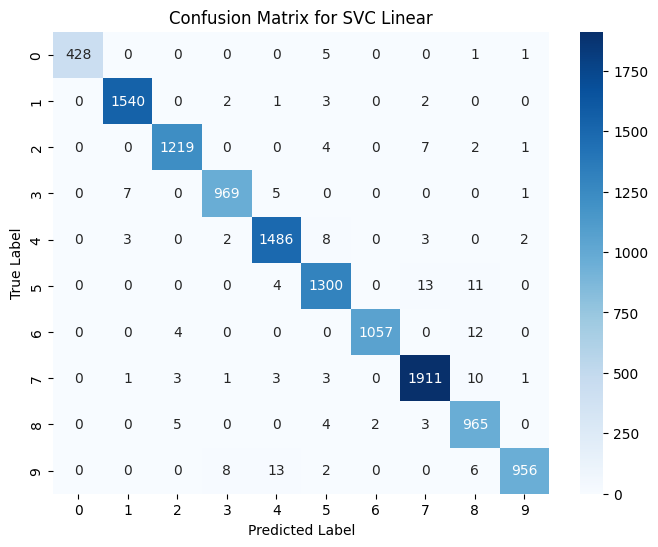


Classifier: SVC RBF
Accuracy: 0.9808
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       435
           1       0.99      0.99      0.99      1548
           2       0.98      0.98      0.98      1233
           3       0.98      0.99      0.98       982
           4       0.98      0.98      0.98      1504
           5       0.97      0.98      0.98      1328
           6       0.99      0.99      0.99      1073
           7       0.98      0.98      0.98      1933
           8       0.96      0.97      0.97       979
           9       0.99      0.97      0.98       985

    accuracy                           0.98     12000
   macro avg       0.98      0.98      0.98     12000
weighted avg       0.98      0.98      0.98     12000

Confusion Matrix:
[[ 429    0    0    0    0    4    0    0    2    0]
 [   0 1538    0    1    1    3    0    5    0    0]
 [   0    1 1213    0    0    4    1    8    5    1]
 [ 

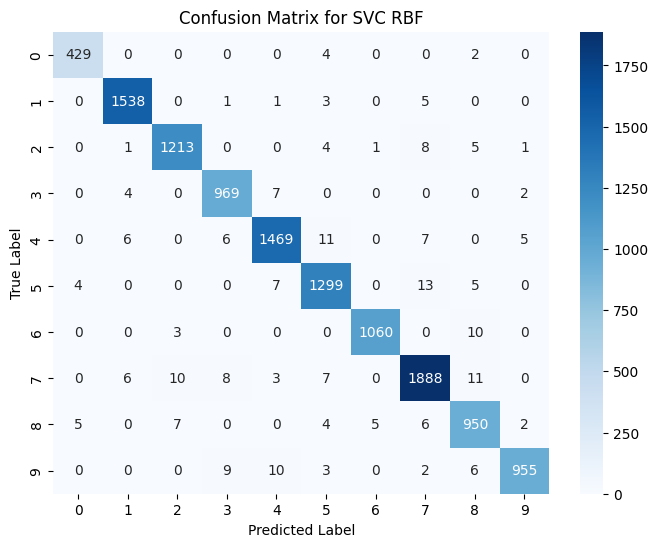


Classifier: Random Forest 1
Accuracy: 0.9446
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.96       435
           1       0.95      0.95      0.95      1548
           2       0.97      0.95      0.96      1233
           3       0.91      0.94      0.93       982
           4       0.93      0.91      0.92      1504
           5       0.92      0.95      0.94      1328
           6       0.99      0.97      0.98      1073
           7       0.94      0.95      0.95      1933
           8       0.94      0.95      0.94       979
           9       0.94      0.92      0.93       985

    accuracy                           0.94     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.94      0.94      0.94     12000

Confusion Matrix:
[[ 417    0    0    0    0   14    0    0    3    1]
 [   0 1477    1   24    5    9    0   32    0    0]
 [   0    1 1176    0    0    7    8   29    7  

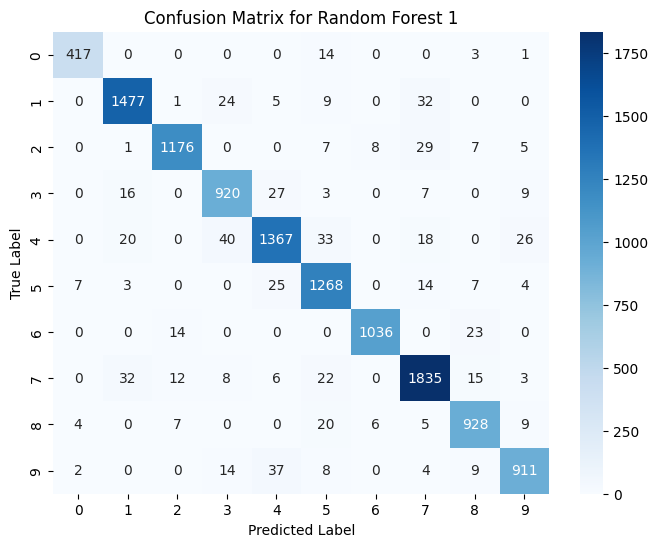


Classifier: Random Forest 2
Accuracy: 0.9434
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.96      0.97       435
           1       0.96      0.95      0.95      1548
           2       0.97      0.95      0.96      1233
           3       0.92      0.94      0.93       982
           4       0.94      0.91      0.92      1504
           5       0.91      0.95      0.93      1328
           6       0.98      0.96      0.97      1073
           7       0.94      0.95      0.94      1933
           8       0.93      0.95      0.94       979
           9       0.93      0.93      0.93       985

    accuracy                           0.94     12000
   macro avg       0.95      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000

Confusion Matrix:
[[ 417    0    0    0    0   13    0    0    4    1]
 [   0 1473    1   26    5   12    0   31    0    0]
 [   0    1 1177    0    0    7    8   28    7  

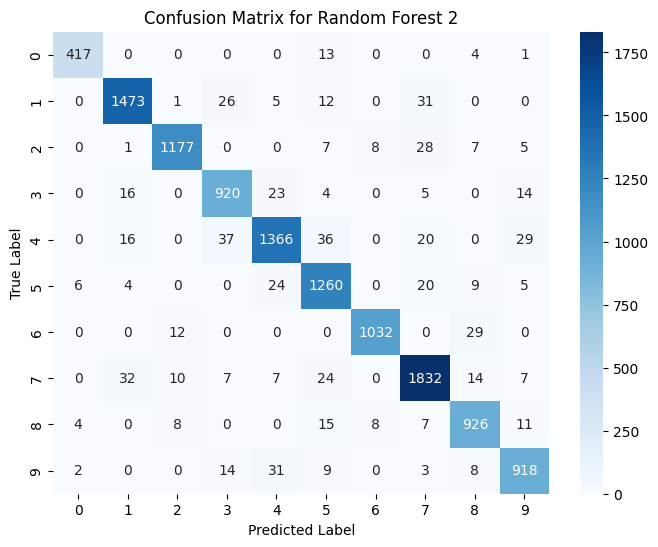


Classifier: Random Forest 3
Accuracy: 0.9410
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.94      0.96       435
           1       0.95      0.95      0.95      1548
           2       0.98      0.95      0.96      1233
           3       0.91      0.93      0.92       982
           4       0.93      0.91      0.92      1504
           5       0.91      0.95      0.93      1328
           6       0.98      0.96      0.97      1073
           7       0.94      0.95      0.94      1933
           8       0.92      0.95      0.93       979
           9       0.93      0.93      0.93       985

    accuracy                           0.94     12000
   macro avg       0.94      0.94      0.94     12000
weighted avg       0.94      0.94      0.94     12000

Confusion Matrix:
[[ 409    0    0    0    0   17    0    0    6    3]
 [   0 1472    1   26    4   14    0   31    0    0]
 [   0    0 1177    0    0    6    9   28    9  

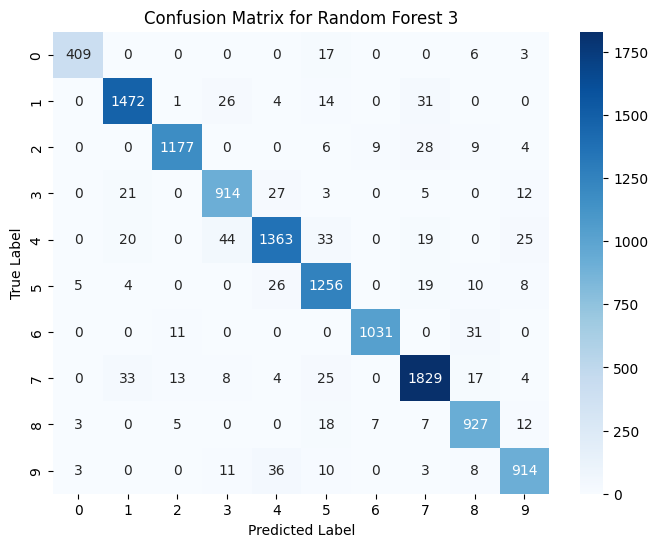


Classifier: Neural Network 1
Accuracy: 0.9485
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       435
           1       0.98      0.98      0.98      1548
           2       0.94      0.93      0.93      1233
           3       0.97      0.97      0.97       982
           4       0.93      0.96      0.94      1504
           5       0.94      0.93      0.94      1328
           6       0.94      0.93      0.93      1073
           7       0.96      0.97      0.96      1933
           8       0.89      0.91      0.90       979
           9       0.97      0.94      0.95       985

    accuracy                           0.95     12000
   macro avg       0.95      0.95      0.95     12000
weighted avg       0.95      0.95      0.95     12000

Confusion Matrix:
[[ 414    0    0    0    0   12    0    0    6    3]
 [   0 1512    1   10    7    1    0   17    0    0]
 [   0    2 1146    0    0    4   32   34   15 

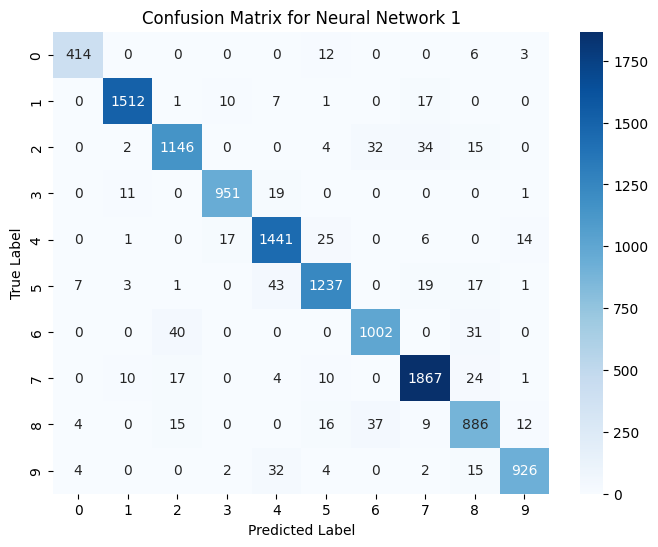


Classifier: Neural Network 2
Accuracy: 0.9277
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.94      0.93       435
           1       0.96      0.95      0.96      1548
           2       0.91      0.89      0.90      1233
           3       0.95      0.94      0.95       982
           4       0.92      0.94      0.93      1504
           5       0.92      0.92      0.92      1328
           6       0.93      0.94      0.93      1073
           7       0.92      0.93      0.92      1933
           8       0.89      0.89      0.89       979
           9       0.95      0.93      0.94       985

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000

Confusion Matrix:
[[ 408    0    0    0    0   17    0    0    5    5]
 [   0 1478    0   13   13    8    0   36    0    0]
 [   0    1 1092    0    0    4   40   73   23 

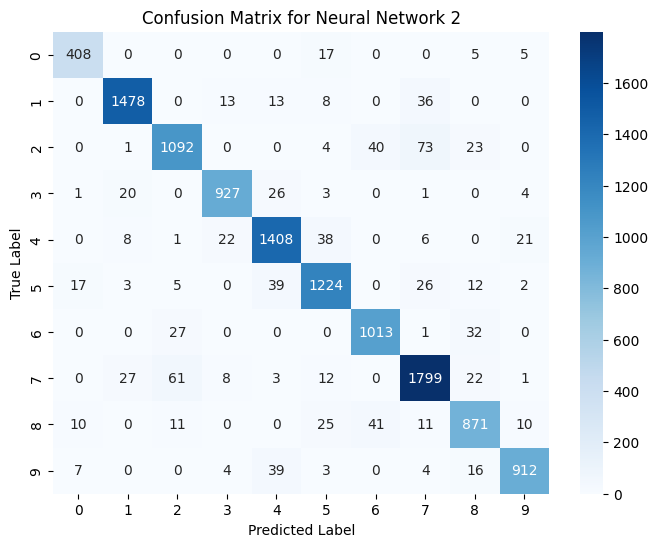


Classifier: Neural Network 3
Accuracy: 0.9314
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       435
           1       0.96      0.96      0.96      1548
           2       0.91      0.89      0.90      1233
           3       0.94      0.97      0.95       982
           4       0.93      0.95      0.94      1504
           5       0.94      0.92      0.93      1328
           6       0.94      0.95      0.95      1073
           7       0.92      0.92      0.92      1933
           8       0.89      0.89      0.89       979
           9       0.95      0.93      0.94       985

    accuracy                           0.93     12000
   macro avg       0.93      0.93      0.93     12000
weighted avg       0.93      0.93      0.93     12000

Confusion Matrix:
[[ 399    0    0    0    0   16    0    0    7   13]
 [   0 1486    0   15   10    0    0   37    0    0]
 [   0    0 1103    0    0    5   24   79   22 

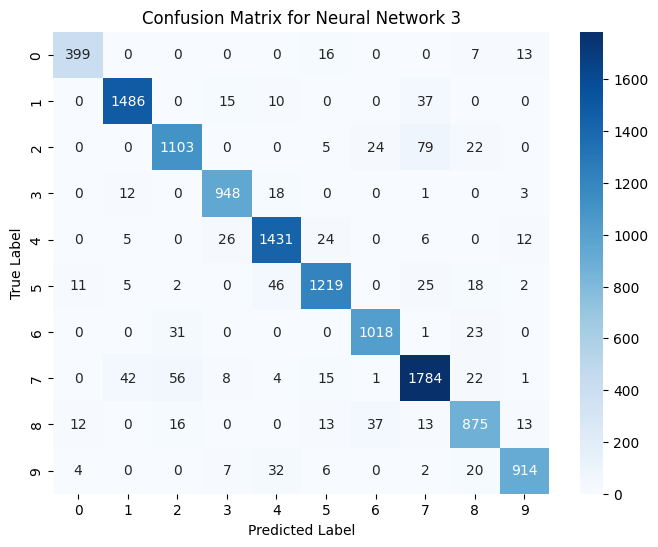

In [113]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np



# Assuming X_train, X_val, y_train, y_val are already defined from the previous code

# Define the classifiers to evaluate
classifiers = {
    "SVC Linear": SVC(kernel='linear', random_state=42),
    "SVC RBF": SVC(kernel='rbf', random_state=42),
    "Random Forest 1": RandomForestClassifier(min_samples_leaf=1, random_state=42),
    "Random Forest 2": RandomForestClassifier(min_samples_leaf=3, random_state=42),
    "Random Forest 3": RandomForestClassifier(min_samples_leaf=5, random_state=42),
    "Neural Network 1": MLPClassifier(hidden_layer_sizes=(5,), random_state=42, max_iter=200),
    "Neural Network 2": MLPClassifier(hidden_layer_sizes=(5,5,), random_state=42, max_iter=200),
    "Neural Network 3": MLPClassifier(hidden_layer_sizes=(5,5,5,), random_state=42, max_iter=200),
}

# Evaluate each classifier
results = {}
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)

    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred)
    conf_matrix = confusion_matrix(y_val, y_pred)

    results[name] = {
        "accuracy": accuracy,
        "report": report,
        "confusion_matrix": conf_matrix
    }
    print(f"{name} Accuracy: {accuracy:.4f}")
    print("-" * 30)

# Print evaluation results and confusion matrices
print("\n--- Classifier Evaluation Results ---")
for name, result in results.items():
    print(f"\nClassifier: {name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['report'])

    print("Confusion Matrix:")
    print(result['confusion_matrix'])

    # Optional: Visualize the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(result['confusion_matrix'], annot=True, fmt='d', cmap='Blues',
                xticklabels=np.unique(y_val), yticklabels=np.unique(y_val))
    plt.title(f"Confusion Matrix for {name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    print("=" * 50)